## Assignment: Image recognition
- Alumno 1: José Antonio Ruiz Heredia
- Alumno 2: Álvaro Honrubia
- Alumno 3: Hector Carlos Flores Reynoso 

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/4oNHlRFEd71HXp4](https://drive.upm.es/s/4oNHlRFEd71HXp4)

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-04-07 00:01:23.194608: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 00:01:23.220995: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-07 00:01:23.221023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-07 00:01:23.221730: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-07 00:01:23.226575: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-04-07 00:01:24.624459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-07 00:01:24.651975: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-07 00:01:24.652012: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [3]:
categories = {0: 'Cargo plane', 1: 'Helicopter', 2: 'Small car', 3: 'Bus', 4: 'Truck', 5: 'Motorboat', 6: 'Fishing vessel', 7: 'Dump truck', 8: 'Excavator', 9: 'Building', 10: 'Storage tank', 11: 'Shipping container'}

In [4]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open('./xview_recognition/'+filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [ ]:
import json

# Load database
json_file = '../input/xview-recognition/xview_recognition/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [6]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Helicopter': 70, 'Small car': 4290, 'Bus': 2155, 'Truck': 2746, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 4689, 'Storage tank': 1469, 'Shipping container': 1523}


In [7]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)
print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

Number of training images: 19239
Number of validation images: 2138


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, ReLU
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import L1, L2  # Lasso regularizer (L1) & Ridge regularizer (L2)

print('Load model')

model = Sequential()

# Input layer
model.add(Flatten(input_shape=(224, 224, 3)))

model.add(Dense(units=1024))
model.add(ReLU(negative_slope=0.005)) 

model.add(Dense(units=512))
model.add(ReLU(negative_slope=0.005)) 

model.add(Dense(units=256))
model.add(ReLU(negative_slope=0.005)) 

model.add(Dense(units=128))
model.add(ReLU(negative_slope=0.005)) 

model.add(Dense(units=64))
model.add(ReLU(negative_slope=0.005))
    
# Output layer
model.add(Dense(len(categories), activation='softmax'))

model.summary()


Load model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 1024)              154141696 
                                                                 
 re_lu (ReLU)                (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 re_lu_1 (ReLU)              (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 re_lu_2 (ReLU)              (None, 256)     

2025-04-07 00:01:25.401923: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-07 00:01:25.402003: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-07 00:01:25.402018: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-07 00:01:25.496561: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-07 00:01:25.496606: I external/local_xla/xla/stream_executor

In [9]:
from tensorflow.keras.optimizers import Adam

## Learning rate is changed (0.0001)
## beta 1: controls the exponential decay rate for the 1st moment (0.8)
## beta 2: controls the 2nd moment decay, fine-tuned for specific tasks. (0.999)
## epsilon: avoid numerical instability (1e-9)

opt = Adam(learning_rate=0.0005, beta_1=0.8999999999999999, beta_2=0.9770000000000001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
## Change the factor to 0.5 and patience to 5 to make the learning rate decrease.
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.5, patience=5, verbose=1)
## Reduce the patience to stop early if the model doesn’t improve
early_stop = EarlyStopping('val_accuracy', patience=10, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [11]:
def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [12]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 128 ## Increase bach size (128) 
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

In [13]:
import math
import numpy as np

print('Training model')
epochs = 100 ## Increase epochs (100) 
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model
Epoch 1/100


2025-04-07 00:01:34.249650: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff82d0b6f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-07 00:01:34.249681: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-04-07 00:01:34.274780: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-07 00:01:34.323000: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1743984094.492652    2382 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


151/151 [==============================] - ETA: 0s - loss: 741.0006 - accuracy: 0.2047
Epoch 1: val_accuracy improved from -inf to 0.16791, saving model to model.keras
151/151 [==============================] - 993s 7s/step - loss: 741.0006 - accuracy: 0.2047 - val_loss: 233.1280 - val_accuracy: 0.1679 - lr: 5.0000e-04
Epoch 2/100
151/151 [==============================] - ETA: 0s - loss: 88.1694 - accuracy: 0.2626
Epoch 2: val_accuracy improved from 0.16791 to 0.33910, saving model to model.keras
151/151 [==============================] - 466s 3s/step - loss: 88.1694 - accuracy: 0.2626 - val_loss: 35.9692 - val_accuracy: 0.3391 - lr: 5.0000e-04
Epoch 3/100
151/151 [==============================] - ETA: 0s - loss: 26.2824 - accuracy: 0.2448
Epoch 3: val_accuracy did not improve from 0.33910
151/151 [==============================] - 773s 5s/step - loss: 26.2824 - accuracy: 0.2448 - val_loss: 43.8528 - val_accuracy: 0.0655 - lr: 5.0000e-04
Epoch 4/100
151/151 [=========================

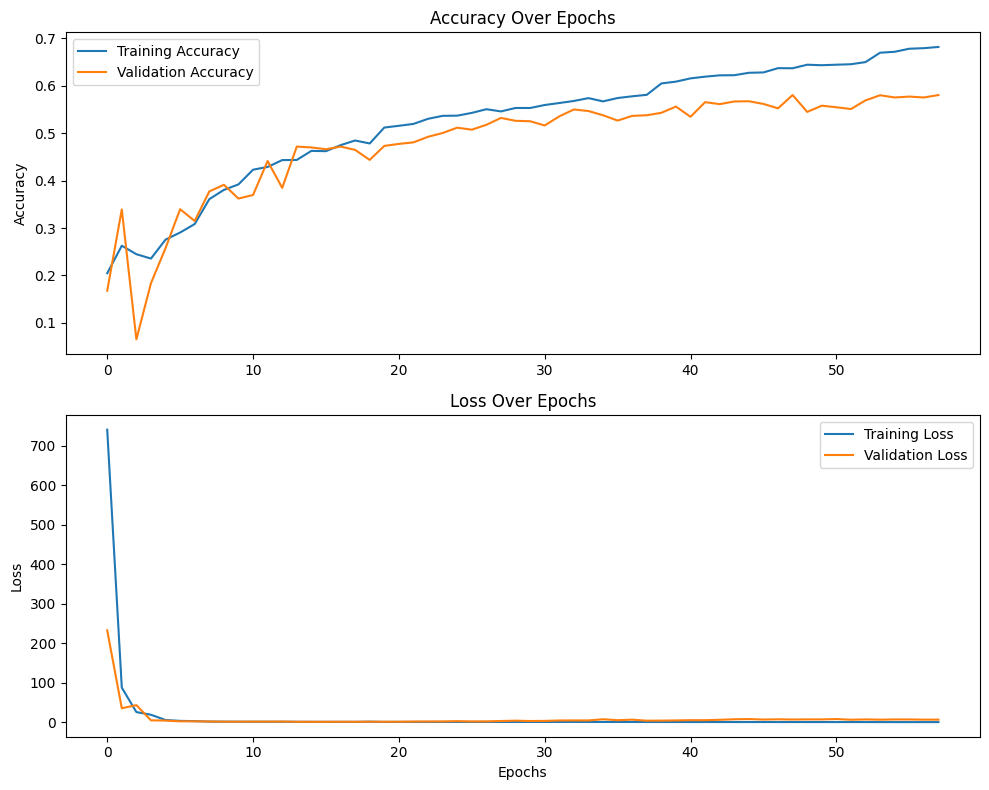

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy/loss
plt.figure(figsize=(10, 8))

# Accuracy
plt.subplot(2, 1, 1)
plt.plot(h.history['accuracy'], label='Training Accuracy')
plt.plot(h.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss
plt.subplot(2, 1, 2)
plt.plot(h.history['loss'], label='Training Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

#### Validation
Compute validation metrics.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

In [ ]:
import numpy as np

model.load_weights('/kaggle/working/model.keras')
y_true, y_pred = [], []
for ann in anns_valid:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [ ]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

#### Testing
Try to improve the results provided in the competition.

In [ ]:
import os
import numpy as np

anns = []
for (dirpath, dirnames, filenames) in os.walk('../input/xview-recognition/xview_recognition/xview_test'):
    for filename in filenames:
        image_path = os.path.relpath(os.path.join(dirpath, filename), '../input/xview-recognition/xview_recognition/')
        image = GenericImage(image_path)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = dirpath[dirpath.rfind('/')+1:]
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

In [ ]:
import numpy as np

model.load_weights('/kaggle/working/model.kerass')
predictions_data = {"images": {}, "annotations": {}}
for idx, ann in enumerate(anns):
    image_data = {"image_id": ann.filename.split('/')[-1], "filename": ann.filename, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
    predictions_data["images"][idx] = image_data
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
        predictions_data["annotations"][idx] = annotation_data

In [ ]:
with open("/kaggle/working/prediction.jsonn", "w") as outfile:
    json.dump(predictions_data, outfile)